II. Попередня обробка зображень, детекція та сегментація об'єктів на зображеннях
================================================================================

_Image Analysis with Python and Napari, Bioinformatics for Ukraine course, 6-24 October 2025, Kyiv, Ukraine._

_© Borys Olifirov, 2025_

__План:__
- Складніші способи оцінки фони (rolling ball)
- Сегментація зображень, побудова масок із використанням алгоритма Отсу
- Багаторівненва сегментація
- Фільтрація зображень, фільтр Гауса та медіанний фільтр
- Морфологічні операції із масками
- Модулі python (`__init__.py`)

---

In [1]:
import numpy as np
import skimage  # scikit-image
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

# Фільтрація зображень
---

In [2]:
crop_image = skimage.io.imread('demo_data/2D_grey_matter_neurofilaments.tif')[1100:1500,350:750]


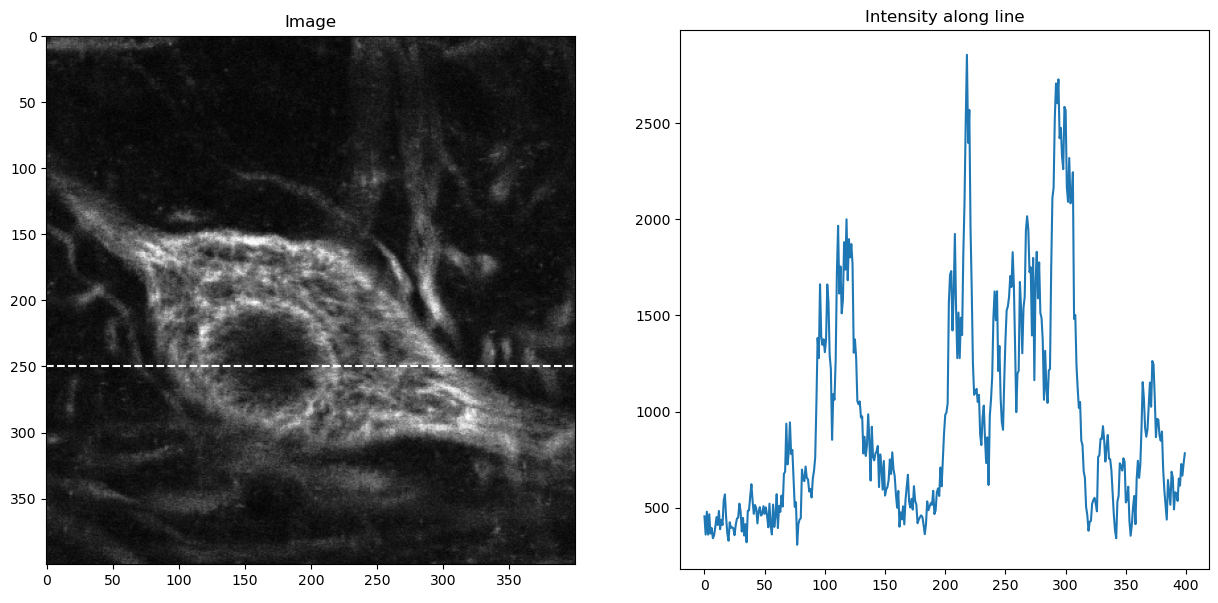

In [3]:
line_num = 250
image_line = crop_image[line_num,:]


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))

ax0.imshow(crop_image, cmap='Greys_r')
ax0.axhline(line_num, color='w', linestyle='--')  # додаємо обрану лінію зображення
ax0.set_title('Image')

ax1.plot(image_line)
ax1.set_title('Intensity along line')
plt.show()

##### Медіанний фільтр

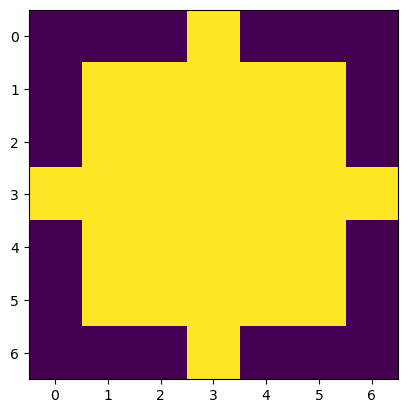

In [4]:
disk_fooprint = skimage.morphology.disk(3)  # структурний елемент для фільтрації
plt.imshow(disk_fooprint)

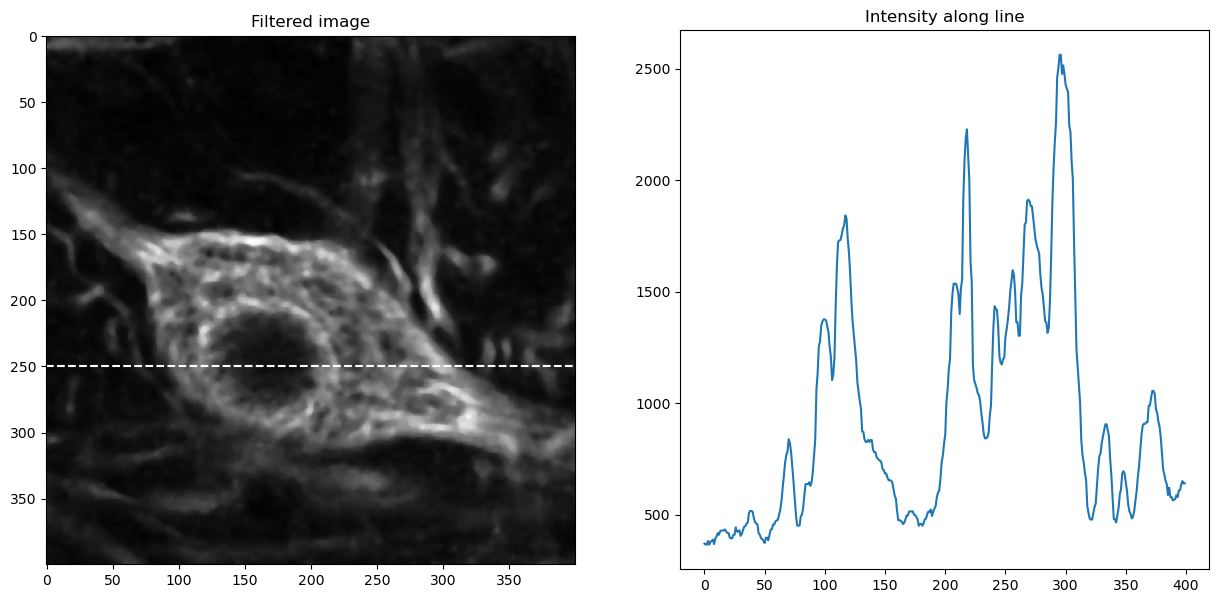

In [5]:
filtered_image_med = skimage.filters.median(crop_image, footprint=skimage.morphology.disk(3))


line_med = filtered_image_med[line_num,:]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(filtered_image_med, cmap='Greys_r')
ax0.axhline(line_num, color='w', linestyle='--')
ax0.set_title('Filtered image')
ax1.plot(line_med)
ax1.set_title('Intensity along line')
plt.show()

##### Фільтр Гауса

![GAUSSIAN](pic/gaussian.png)

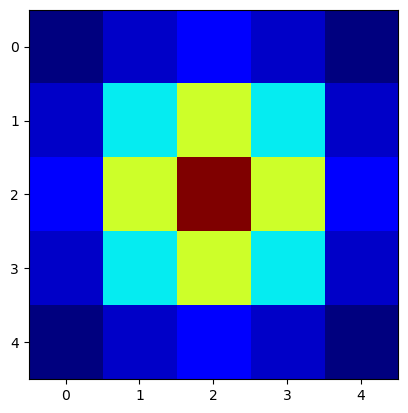

In [7]:
def generate_gaussian_kernel(kernel_size, sigma):
    """
    Генерація 2D Гаусівського ядра.

    Args:
        kernel_size (int): Розмір квадратного ядра (наприклад, 3 для ядра 3x3), непарне число.
        sigma (float): Стандартне відхилення функції Гаусса.

    Returns:
        numpy.ndarray: 2D ядро.
    """
    if kernel_size % 2 == 0:
        raise ValueError("Kernel size must be an odd number.")

    # створення 1D масиву координат, відцентрованого відносно нуля
    ax = np.linspace(-(kernel_size - 1) / 2., (kernel_size - 1) / 2., kernel_size)

    # створення 2D сітки координат
    xx, yy = np.meshgrid(ax, ax)  

    # обчислення значень функції Гаусса
    kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma))

    # нормалізація значень в діапазоні [0, 1]
    return kernel / np.sum(kernel)

kernel_size = 5  
sigma = 1.0
gaussian_kernel = generate_gaussian_kernel(kernel_size, sigma)

plt.imshow(gaussian_kernel, cmap='jet')

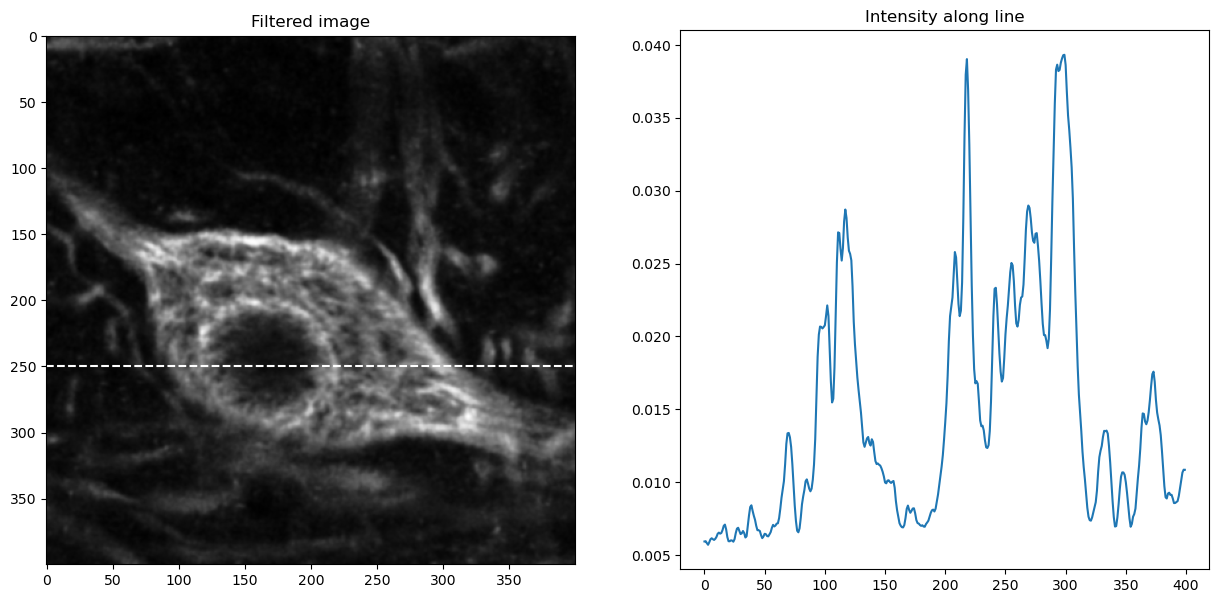

In [8]:
filtered_image_gaus = skimage.filters.gaussian(crop_image, sigma=1)


line_gaus = filtered_image_gaus[line_num,:]

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(filtered_image_gaus, cmap='Greys_r')
ax0.axhline(line_num, color='w', linestyle='--')
ax0.set_title('Filtered image')
ax1.plot(line_gaus)
ax1.set_title('Intensity along line')
plt.show()

### Фільтрацію можна узагальнити до згортки (convolution)

Операція згортки (convolution) з певним ядром може слугувати не лише для згладжування зображень, але й для інших операцій, наприклад виявлення країв (edge detection, Sobel operator).

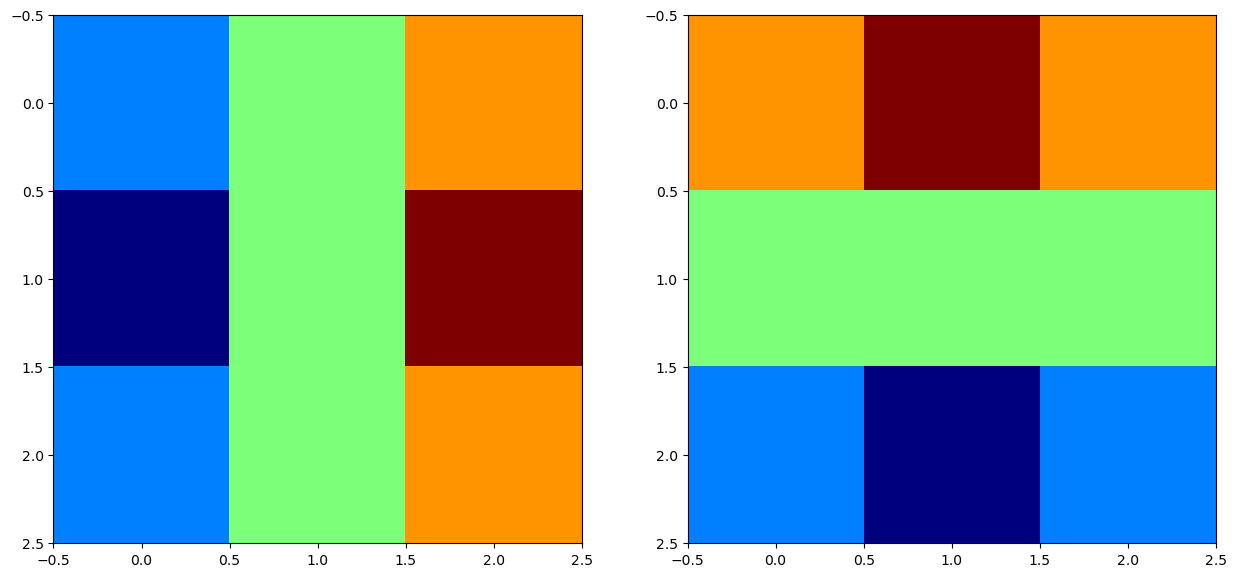

In [10]:
sobel_h = np.array([[-1, 0, 1],  # ядро Собеля для виявлення горизонтальних контурів
                    [-2, 0, 2],
                    [-1, 0, 1]])

sobel_v = np.array([[1, 2, 1],   # ядро Собеля для виявлення вертикальних контурів
                    [0, 0, 0],
                    [-1, -2, -1]])

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(sobel_h, cmap='jet')
ax1.imshow(sobel_v, cmap='jet')
plt.show()

(320, 320)
uint16


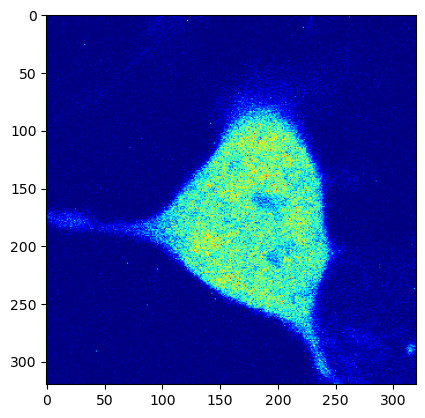

In [11]:
bad_image = skimage.io.imread('demo_data/4D_HEK_spectral_time_series.tiff')[1,4]  # завантаження зображень з використанням skimage
print(bad_image.shape)
print(bad_image.dtype)

plt.imshow(bad_image, cmap='jet')

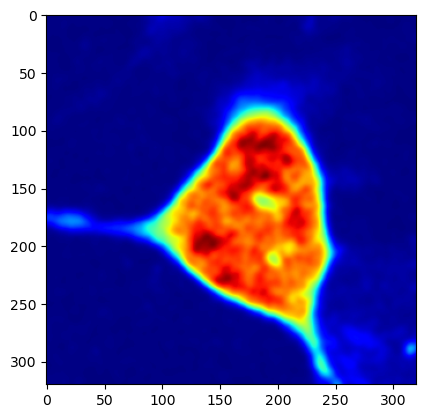

In [12]:
smooth_bad_image = skimage.filters.gaussian(bad_image, sigma=3)

plt.imshow(smooth_bad_image, cmap='jet')

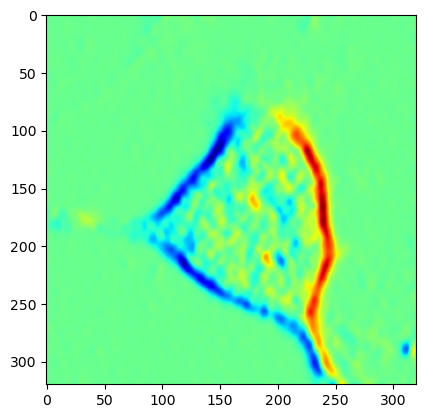

In [13]:
edges_h = ndi.convolve(smooth_bad_image, sobel_h)  # детекція горизонтальних контурів

plt.imshow(edges_h, cmap='jet')  # відображаються вертикальні бо matplotlib використовує (y,x) координати

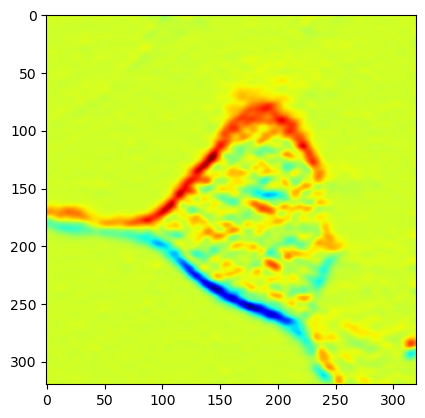

In [14]:
edges_v = ndi.convolve(smooth_bad_image, sobel_v)  # детекція вертикальних контурів

plt.imshow(edges_v, cmap='jet')

Для обєднання двох градієнтів (по вертикалі та горизонталі) використовується піднесення до квадрату та корінь квадратний, щоб визначити повний градієнт.

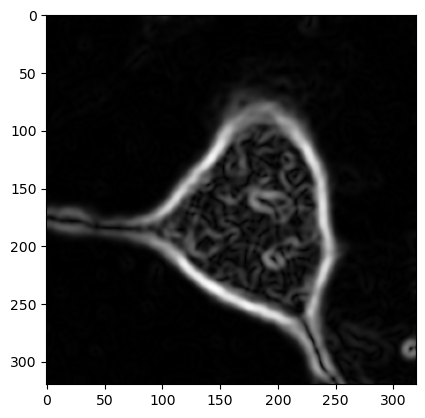

In [15]:
# об'єднання градієнтів по вертикалі та горизонталі, отримання повного зображення контурів
edges = np.sqrt(edges_h**2 + edges_v**2)

plt.imshow(edges, cmap='Greys_r')

# Проста сегментація зображень
---

### Бінарні маски

196
4095


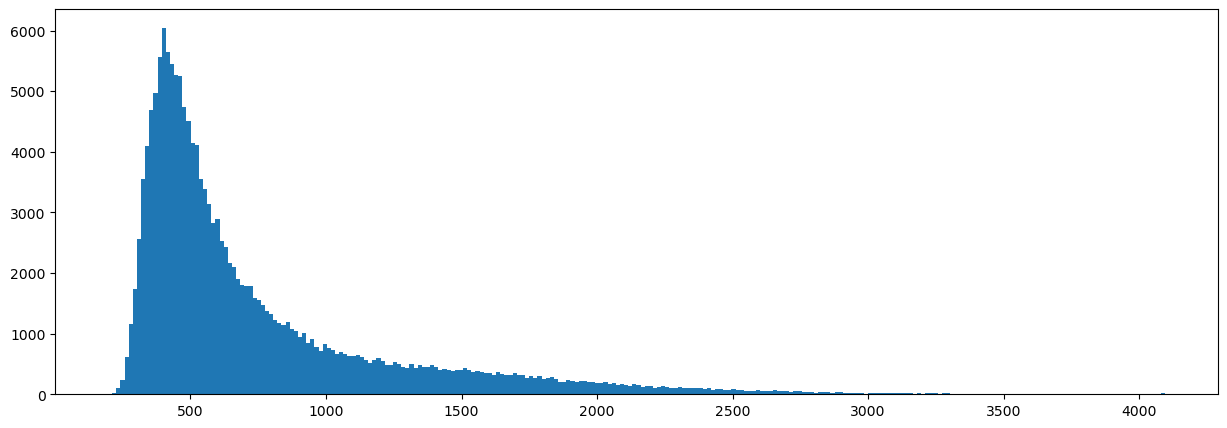

In [16]:
print(crop_image.min())
print(crop_image.max())

plt.figure(figsize=(15,5))
plt.hist(crop_image.ravel(), bins=256)
plt.show()

(400, 400)
(400, 400)


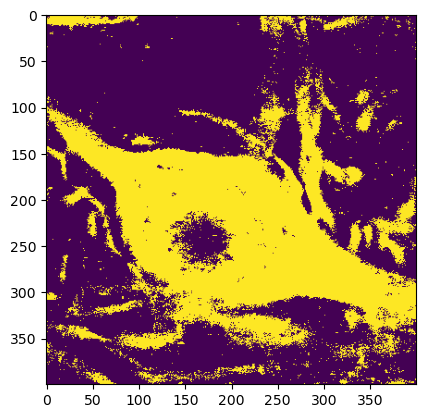

In [17]:
simple_mask = crop_image > 700

print(crop_image.shape)
print(simple_mask.shape)

plt.imshow(simple_mask)

### Сегментація зображення з використання методу Отсу

1129


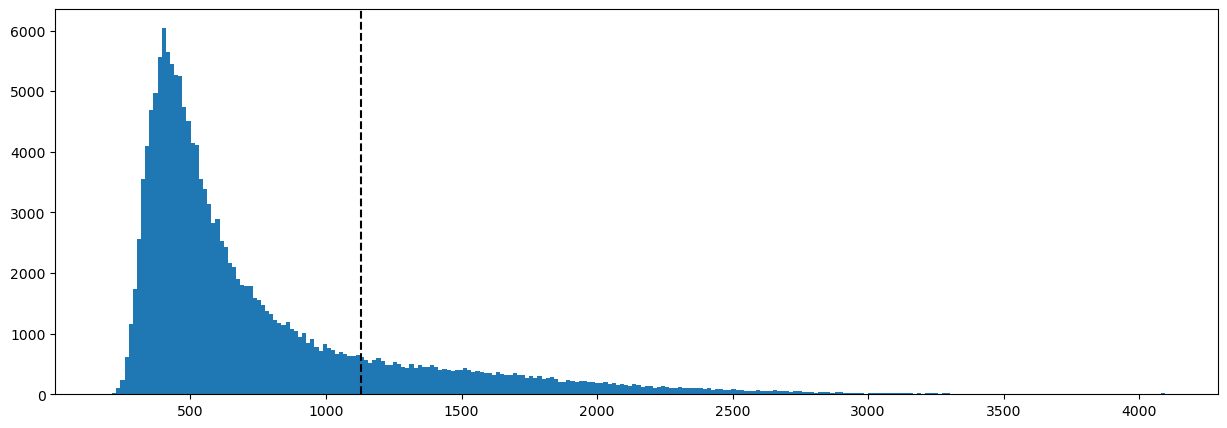

In [18]:
th_otsu = skimage.filters.threshold_otsu(crop_image)
print(th_otsu)

plt.figure(figsize=(15,5))
plt.hist(crop_image.ravel(), bins=256)
plt.axvline(x=th_otsu, linestyle='--', color='k')
plt.show()

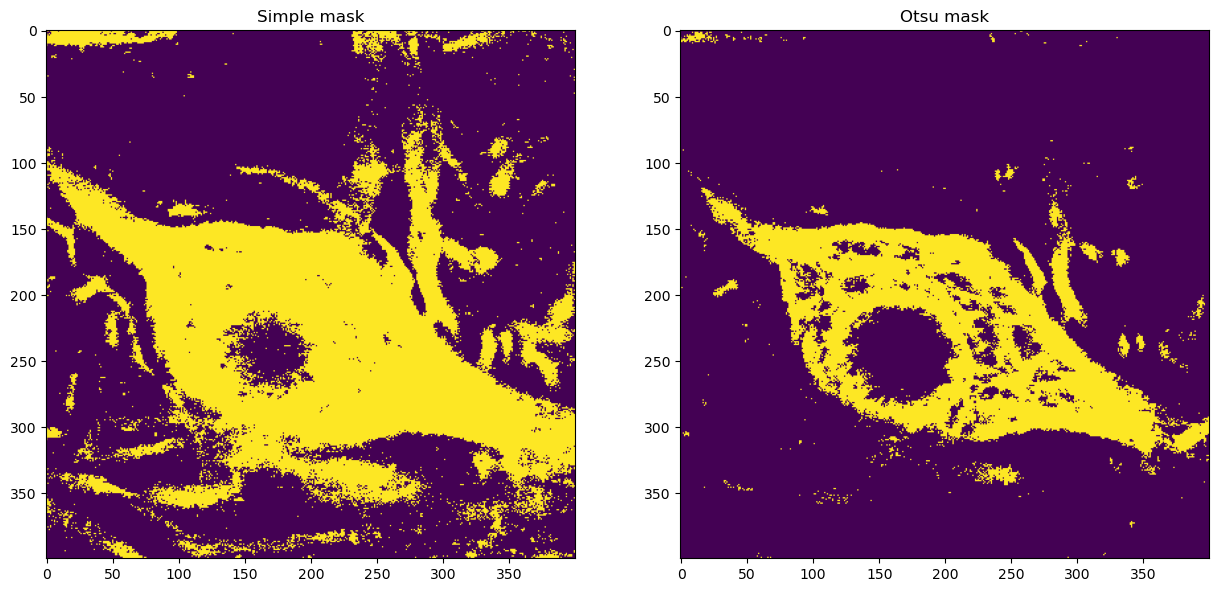

In [19]:
otsu_mask = crop_image > th_otsu

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(simple_mask)
ax0.set_title('Simple mask')
ax1.imshow(otsu_mask)
ax1.set_title('Otsu mask')
plt.show()

Про інші методи простої сегментації можна прочитати у [документації scikit-image](https://scikit-image.org/docs/0.25.x/auto_examples/segmentation/plot_thresholding.html).

### Сегментація зображення з використання методу мульти Отсу

[ 808 1603]


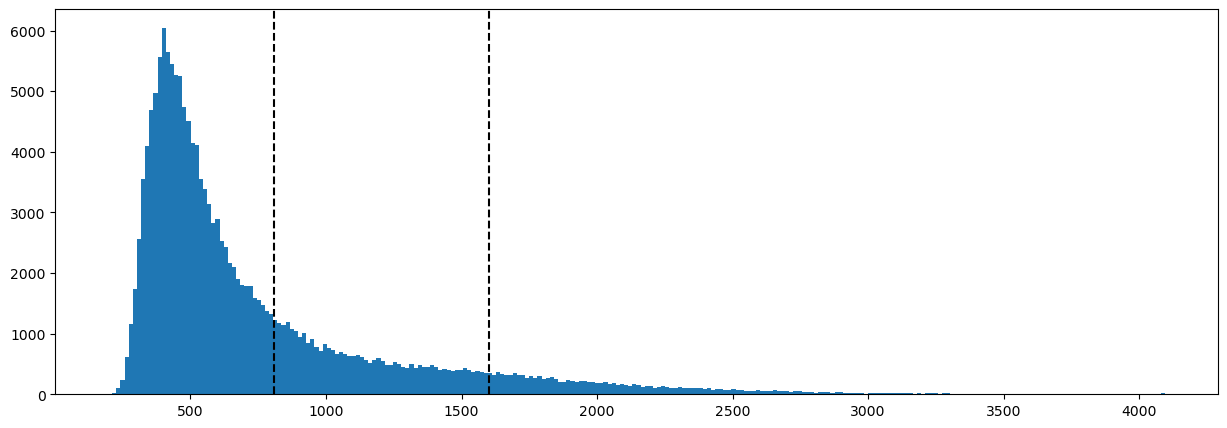

In [20]:
multi_otsu_th = skimage.filters.threshold_multiotsu(crop_image, classes=3)
print(multi_otsu_th)

plt.figure(figsize=(15,5))
plt.hist(crop_image.ravel(), bins=256)
plt.axvline(x=multi_otsu_th[0], linestyle='--', color='k')
plt.axvline(x=multi_otsu_th[-1], linestyle='--', color='k')
plt.show()

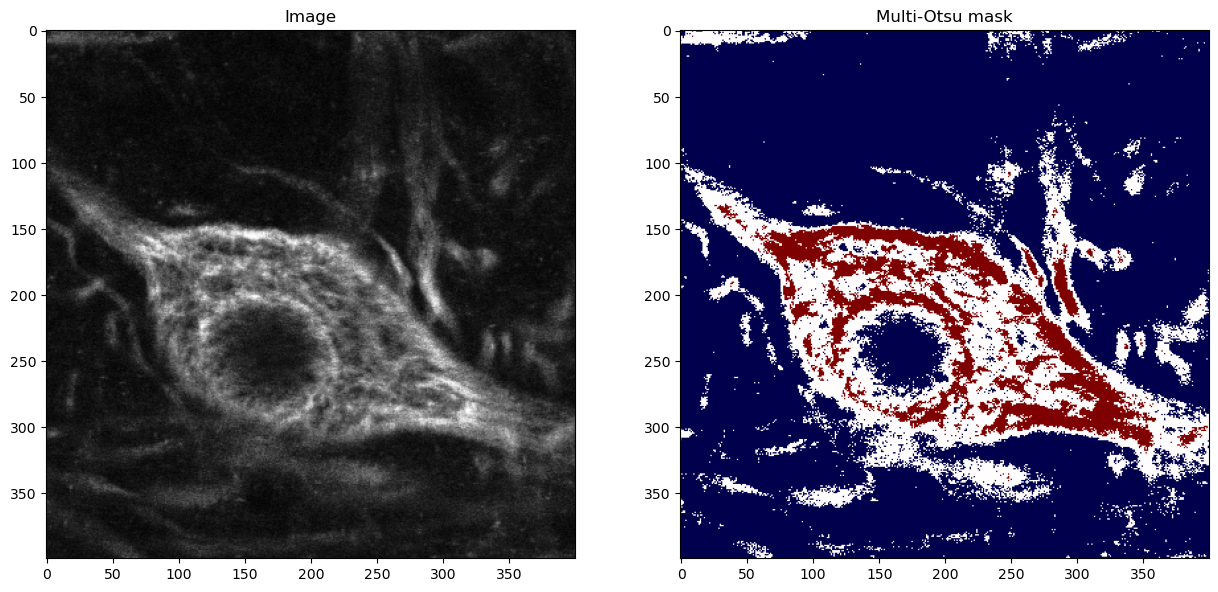

In [21]:
multiotsu_mask = np.digitize(crop_image, bins=multi_otsu_th)  # створення маски на основі порогів

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(crop_image, cmap='Greys_r')
ax0.set_title('Image')
ax1.imshow(multiotsu_mask, cmap='seismic')
ax1.set_title('Multi-Otsu mask')
plt.show()

### Попередня обробка та фільтрація дозволяє покращити якість сегментації

In [29]:
# функція для корекції фону з попередньої зустрічі
def background_correction(input_img:np.ndarray, background_percentile:float=1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

In [30]:
corrected_image = background_correction(crop_image, background_percentile=1)
preprocessed_image = skimage.filters.gaussian(crop_image, sigma=1)

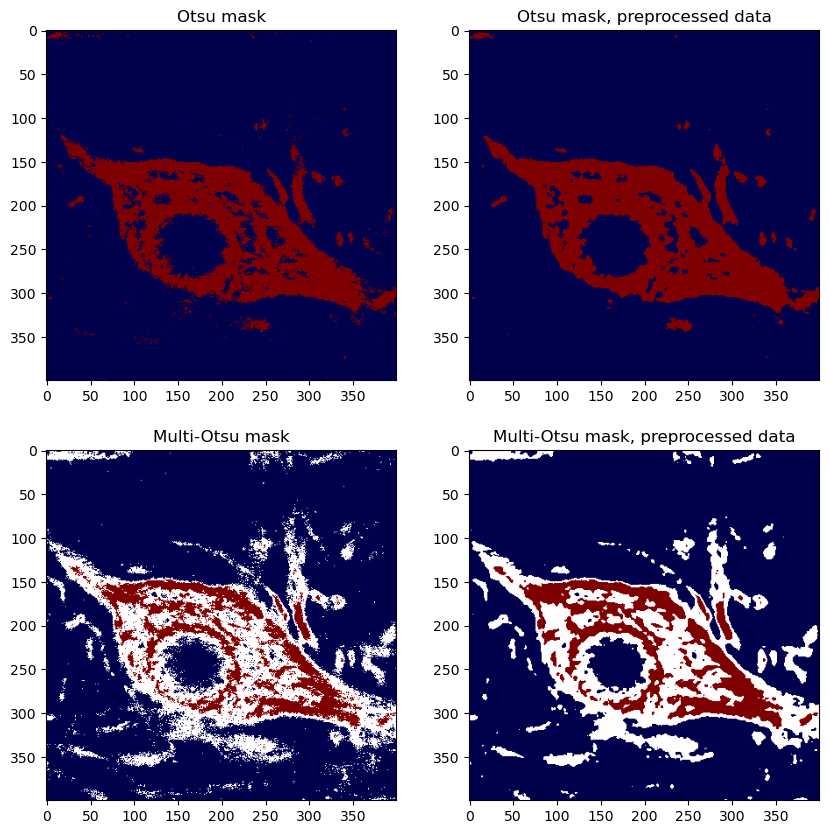

In [31]:
fin_otsu_mask = preprocessed_image > skimage.filters.threshold_otsu(preprocessed_image)

fin_multi_otsu_th = skimage.filters.threshold_multiotsu(preprocessed_image, classes=3)
fin_multiotsu_mask = np.digitize(preprocessed_image, bins=fin_multi_otsu_th)


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))  # альтернативний спосіб створення сітки зображень
ax[0,0].imshow(otsu_mask, cmap='seismic')
ax[0,0].set_title('Otsu mask')
ax[0,1].imshow(fin_otsu_mask, cmap='seismic')
ax[0,1].set_title('Otsu mask, preprocessed data')
ax[1,0].imshow(multiotsu_mask, cmap='seismic')
ax[1,0].set_title('Multi-Otsu mask')
ax[1,1].imshow(fin_multiotsu_mask, cmap='seismic')
ax[1,1].set_title('Multi-Otsu mask, preprocessed data')
plt.show()

# Морфологічні операції із зображеннями
---

(100, 100)


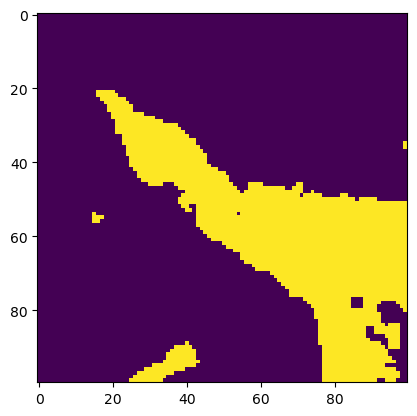

In [25]:
mask_fragment = fin_otsu_mask[100:200,:100]
print(mask_fragment.shape)

plt.imshow(mask_fragment)

### Базові морфологічні операції

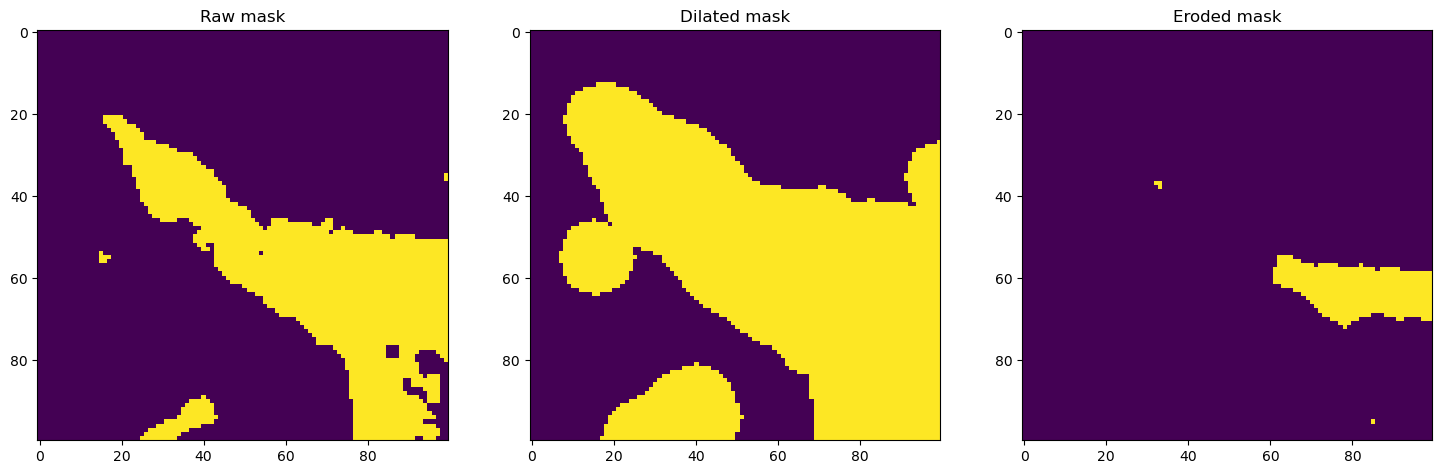

In [26]:
dilated_mask = skimage.morphology.dilation(mask_fragment, footprint=skimage.morphology.disk(8))
eroded_mask = skimage.morphology.erosion(mask_fragment, footprint=skimage.morphology.disk(8))

fig, ax = plt.subplots(ncols=3, figsize=(18,18))
ax[0].imshow(mask_fragment)
ax[0].set_title('Raw mask')
ax[1].imshow(dilated_mask)
ax[1].set_title('Dilated mask')
ax[2].imshow(eroded_mask)
ax[2].set_title('Eroded mask')
plt.show()

### Послідовні морфологічні операції

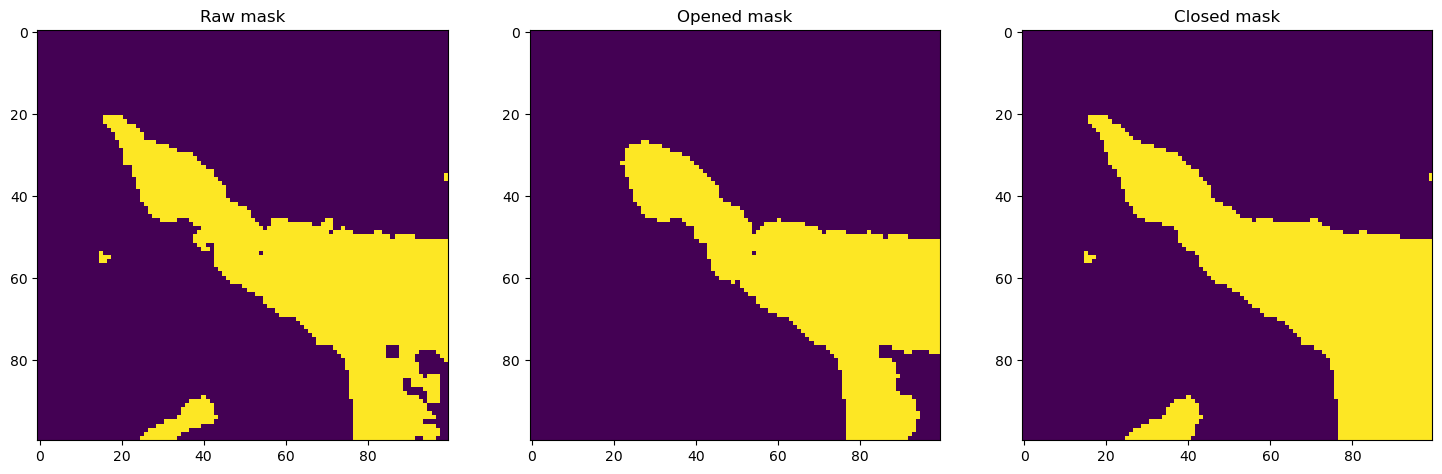

In [32]:
# відкриття є послідовністю ерозії та диляції
opened_mask = skimage.morphology.opening(mask_fragment, footprint=skimage.morphology.disk(5))

# закриття є послідовністю диляції та ерозії
closed_mask = skimage.morphology.closing(mask_fragment, footprint=skimage.morphology.disk(5))


fig, ax = plt.subplots(ncols=3, figsize=(18,18))
ax[0].imshow(mask_fragment)
ax[0].set_title('Raw mask')
ax[1].imshow(opened_mask)
ax[1].set_title('Opened mask')
ax[2].imshow(closed_mask)
ax[2].set_title('Closed mask')
plt.show()

### Процессинг бінарної маски з використанням морфологічних операцій

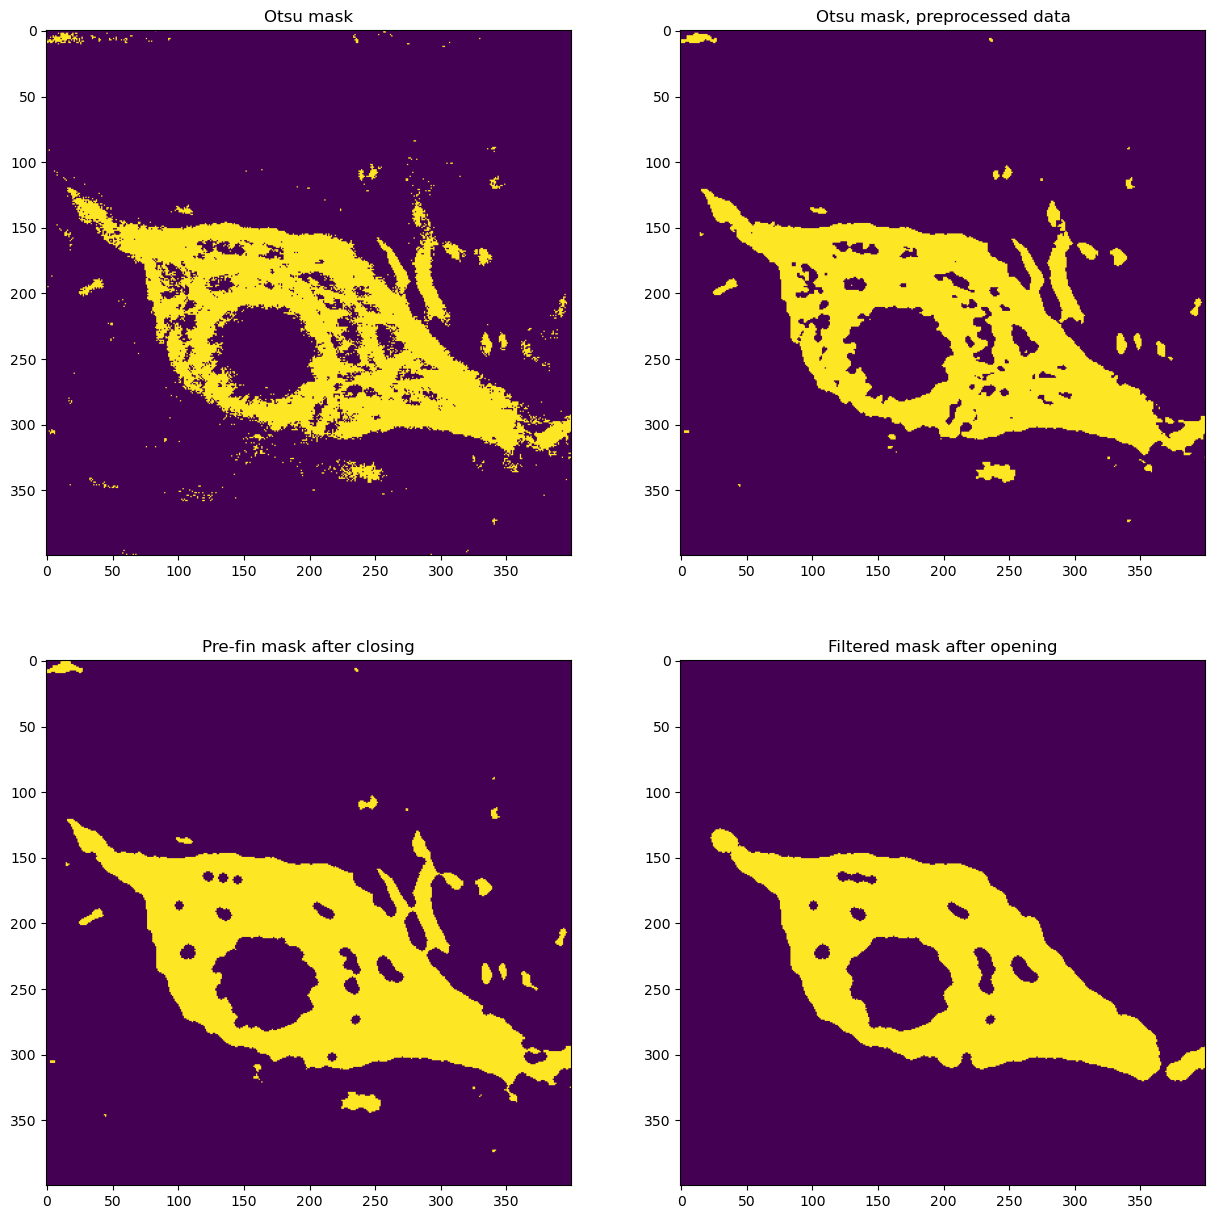

In [33]:
# закриттям маски позбавляємось дрібних прогалин
pre_filtered_mask = skimage.morphology.closing(fin_otsu_mask, footprint=skimage.morphology.disk(3))

# відкриттям маски видаляємо дрібні артефакти поза клітиною
filtered_mask = skimage.morphology.opening(pre_filtered_mask, footprint=skimage.morphology.disk(7))


fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(15,15))
ax[0,0].imshow(otsu_mask)
ax[0,0].set_title('Otsu mask')
ax[0,1].imshow(fin_otsu_mask)
ax[0,1].set_title('Otsu mask, preprocessed data')
ax[1,0].imshow(pre_filtered_mask)
ax[1,0].set_title('Pre-fin mask after closing')
ax[1,1].imshow(filtered_mask)
ax[1,1].set_title('Filtered mask after opening')
plt.show()

# Маскування багатовимірних зображень
---

__Маскування z-стеков__

Часто для подальшого аналізу використовують 2D-похідну стека, проєкцію максимальною інтенсивності (maximum intensity projection/MIP).

Однак якщо поставлена задача не дозволяє знехтувати об'ємною складовою зображення, стає необхідно створювати 3D-маски.


__Маскування часових рядів__

Підхід залежить від того, чи відбувається помітне зміщення об'єктів інтересу між кадрами. У простому випадку можна використати в якості опорного зображення для побудови маски або _перший кадр серії_ (зазвичай, він найбільш яскравий та контрастний), або _усереднене зображення всієї серії_ (дозволяє зменшити фоновий шум на зображенні).

В складнішому випадку помітного зміщення об'єктів між кардами може бути декілька основних підходів:
- Побудова окремих простих масок для кожного кадру
- Компенсація зсувів об'єктів між кадрами вирівнюванням (image registration/image alignment)
- Складніші підходи для трекінгу об'єктів (object trecking).


__Маскування за наявності спектральних каналів__

Послуговуючись логікою описаною вище, у випадку наявності декілької спектральних каналів можна будувати маски для кожного із них окремо.

### Приклад маскування z-стека із двома спектральними каналами

In [34]:
z_stack = skimage.io.imread('demo_data/4D_neuron_z-stack.tif')
print(z_stack.shape)  # [z,s,x,y]

(14, 2, 1340, 1240)


##### Подивимост на окрему фокальну площину в обох каналах

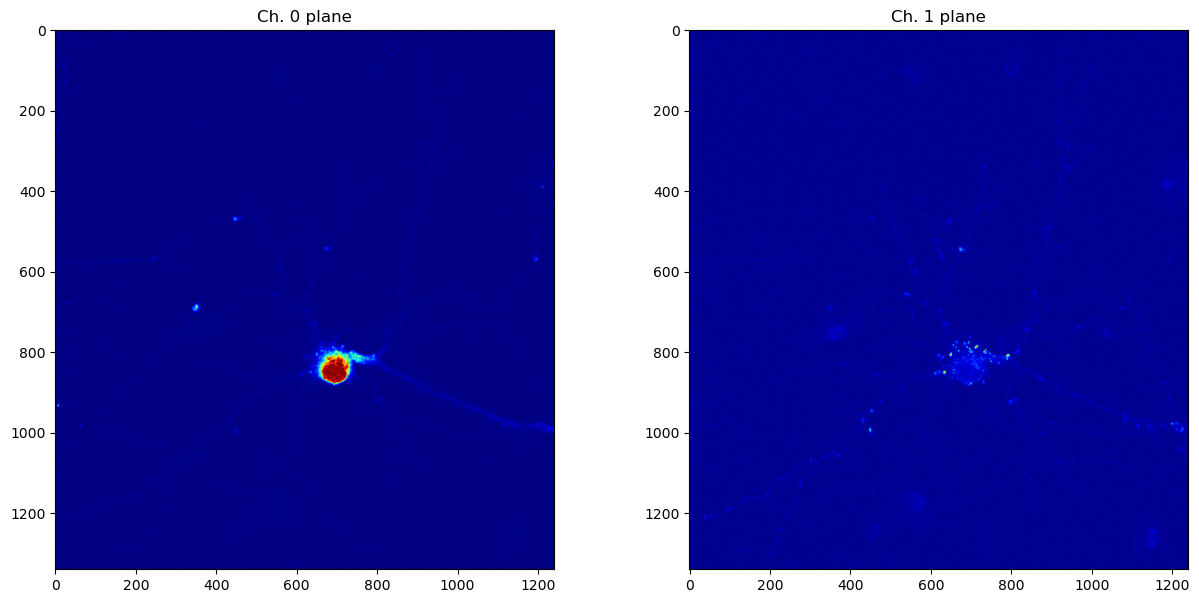

In [35]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(z_stack[5,0], cmap='jet')
ax0.set_title('Ch. 0 plane')
ax1.imshow(z_stack[5,1], cmap='jet')
ax1.set_title('Ch. 1 plane')
plt.show()

##### Зробимо MIP

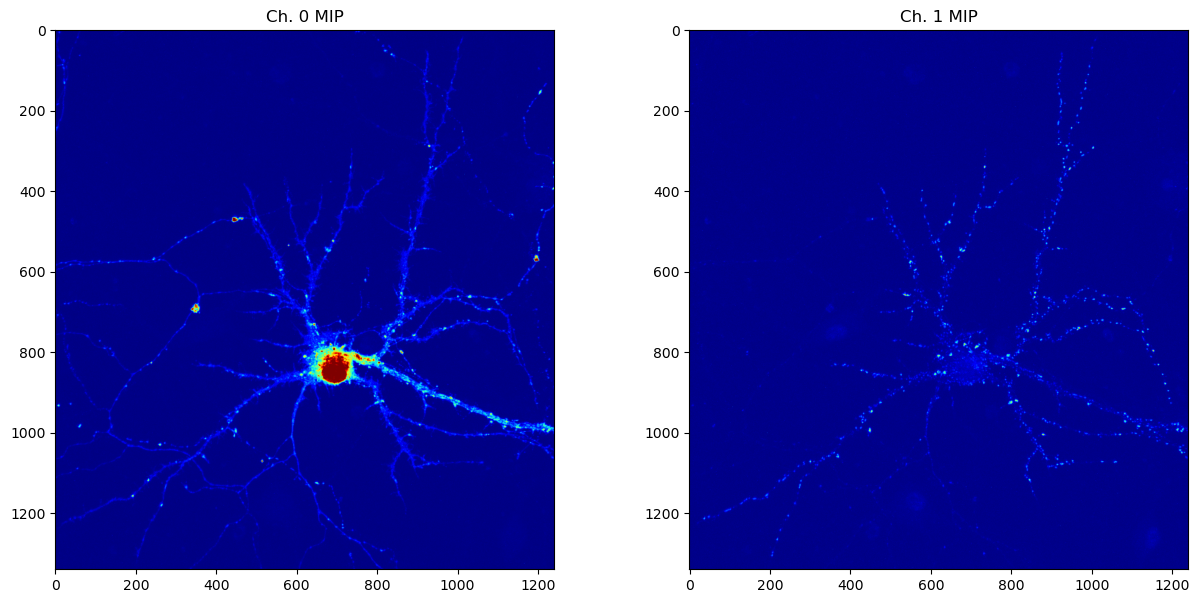

In [36]:
mip_ch0 = np.max(z_stack[:,0], axis=0)
mip_ch1 = np.max(z_stack[:,1], axis=0)

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(mip_ch0, cmap='jet')
ax0.set_title('Ch. 0 MIP')
ax1.imshow(mip_ch1, cmap='jet')
ax1.set_title('Ch. 1 MIP')
plt.show()

##### Попередня обробка MIP

In [37]:
# функція для корекції фону з попередньої зустрічі
def background_correction(input_img:np.ndarray, background_percentile:float=1):
    back_int = np.percentile(input_img, background_percentile)
    corr_img = input_img - back_int
    corr_img = corr_img.clip(min=0)
    return corr_img.astype(input_img.dtype)

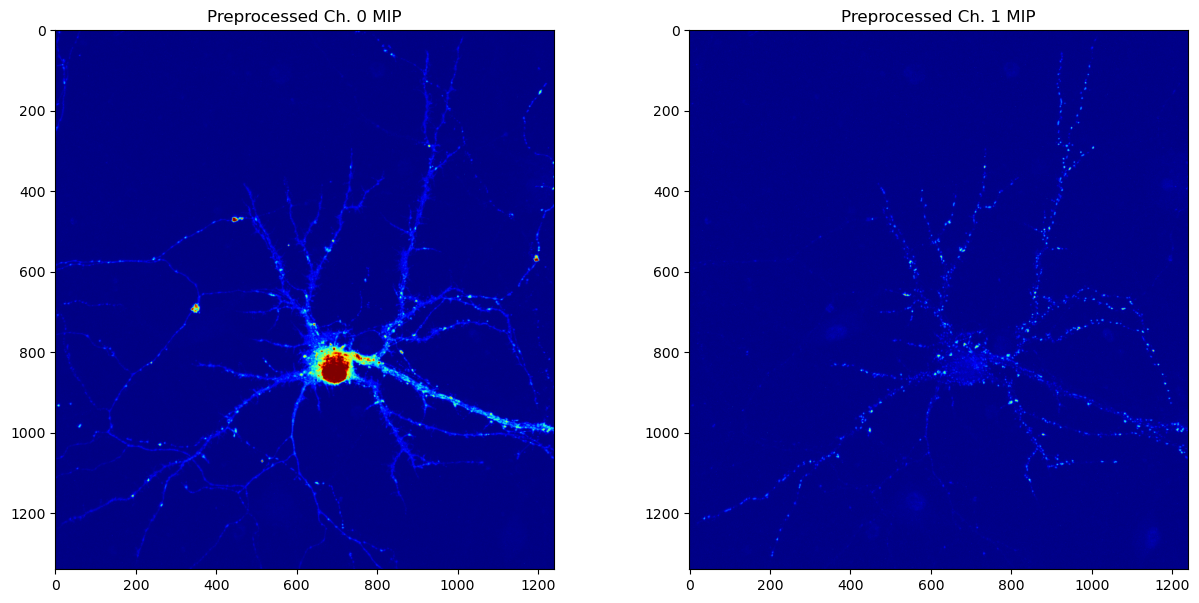

In [38]:
mip_ch0_preproc = background_correction(mip_ch0)
mip_ch1_preproc = background_correction(mip_ch1)


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(mip_ch0_preproc, cmap='jet')
ax0.set_title('Preprocessed Ch. 0 MIP')
ax1.imshow(mip_ch1_preproc, cmap='jet')
ax1.set_title('Preprocessed Ch. 1 MIP')
plt.show()

##### Маскування

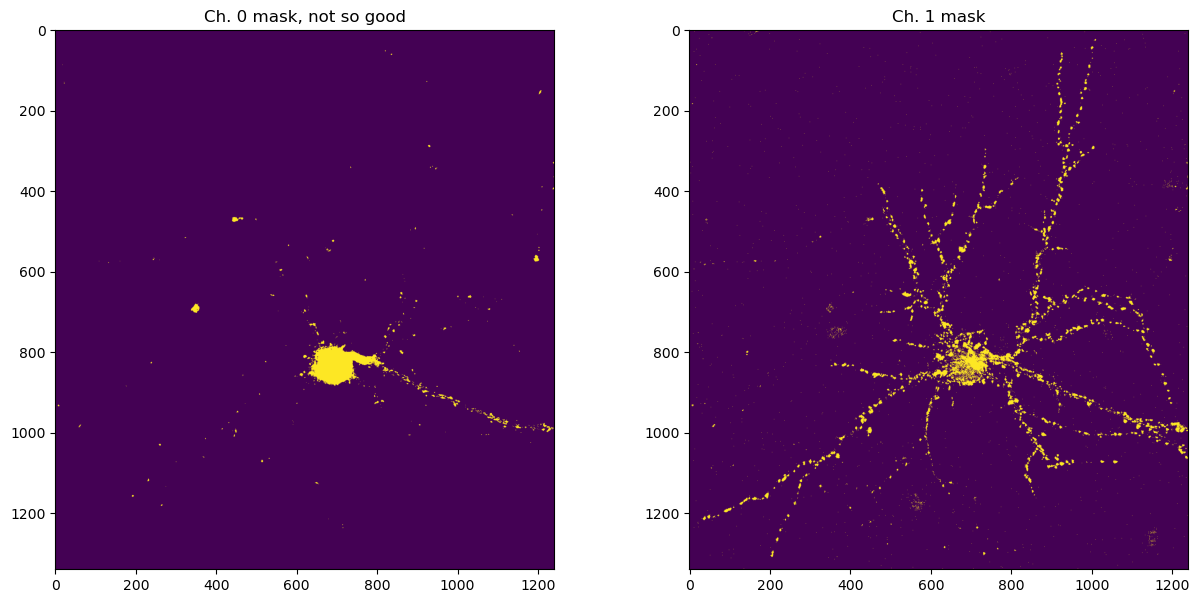

In [39]:
mask_ch0 = mip_ch0 > skimage.filters.threshold_otsu(mip_ch0_preproc)
mask_ch1 = mip_ch1 > skimage.filters.threshold_otsu(mip_ch1_preproc)


fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15,7))
ax0.imshow(mask_ch0)
ax0.set_title('Ch. 0 mask, not so good')
ax1.imshow(mask_ch1)
ax1.set_title('Ch. 1 mask')
plt.show()

##### Локальне маскування за Отсу для дуже контрастних зображень

/Users/romankoval/miniconda3/envs/bioin-img/lib/python3.13/site-packages/skimage/filters/rank/generic.py:332: UserWarning: Bad rank filter performance is expected due to a large number of bins (3950), equivalent to an approximate bitdepth of 11.9.
  image, footprint, out, mask, n_bins = _preprocess_input(


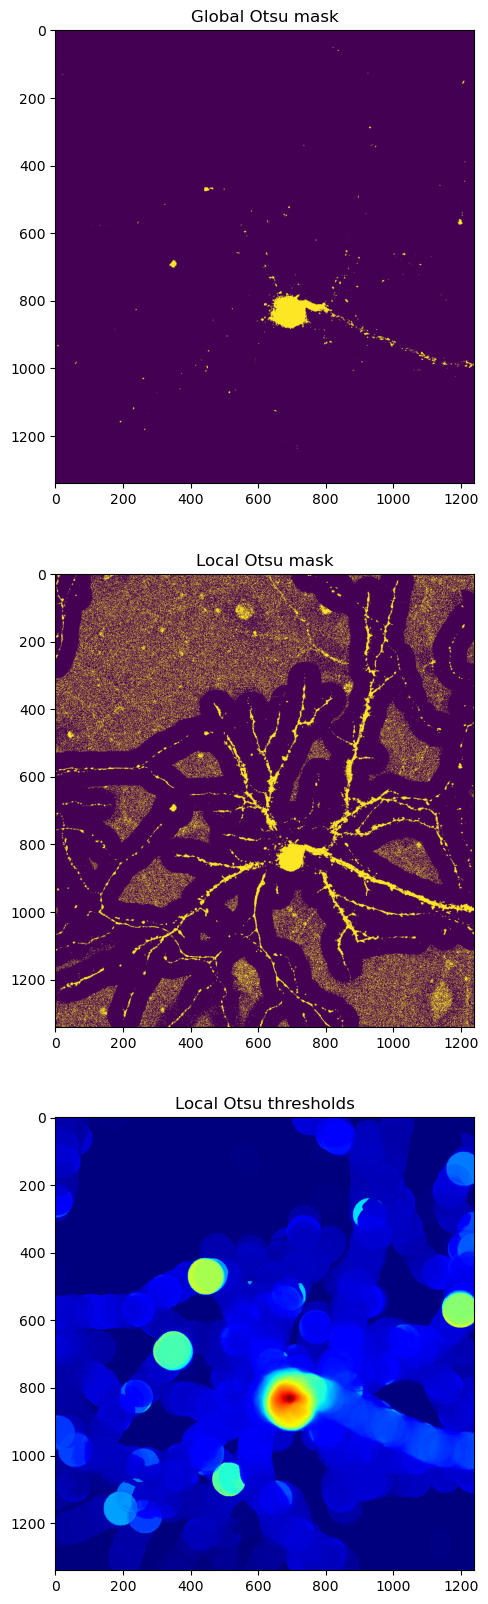

In [40]:
th_local = skimage.filters.rank.otsu(mip_ch0_preproc, footprint=skimage.morphology.disk(50))
mask_ch0_local = mip_ch0_preproc > th_local


fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(10,20))
ax0.imshow(mask_ch0)
ax0.set_title('Global Otsu mask')
ax1.imshow(mask_ch0_local)
ax1.set_title('Local Otsu mask')
ax2.imshow(th_local, cmap='jet')
ax2.set_title('Local Otsu thresholds')
plt.show()

##### Фільтрація локальної маски

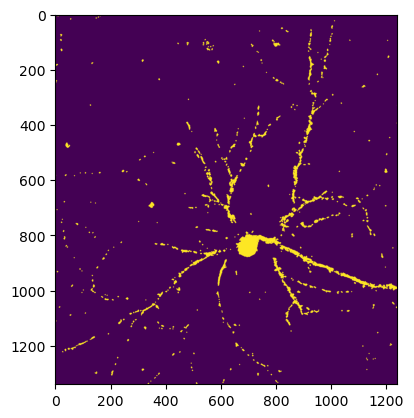

In [41]:
mask_ch0_fin = skimage.morphology.opening(mask_ch0_local, footprint=skimage.morphology.disk(2))

plt.imshow(mask_ch0_fin)

##### Відображення накладання двох кінцевих масок

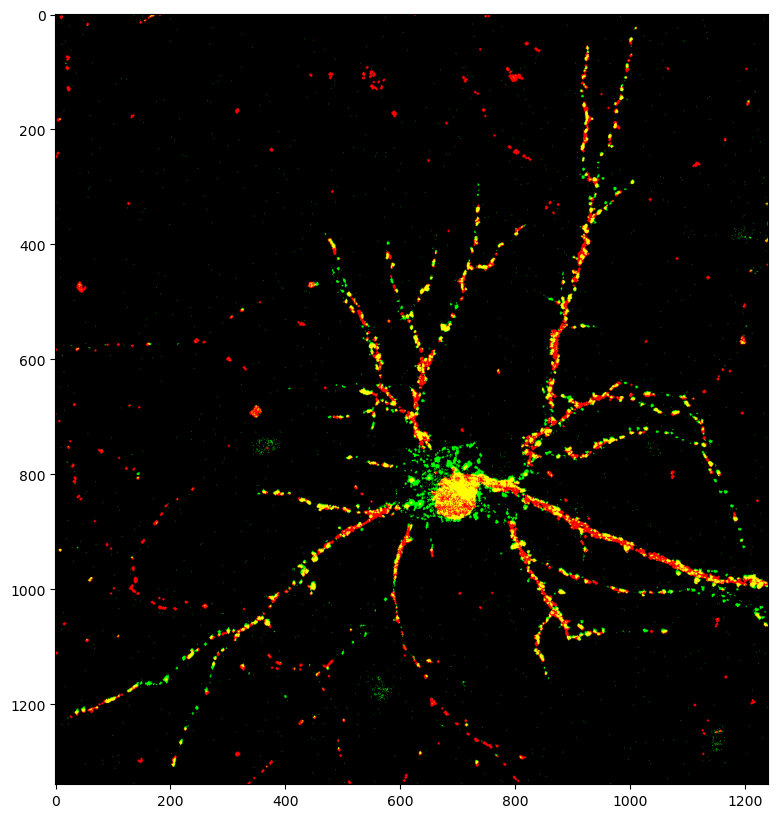

In [42]:
mask_overlap = np.zeros((*mask_ch0_fin.shape, 3), dtype=np.uint8)  # створюємо порожненє RGB зображення
mask_overlap[mask_ch0_fin, 0] = 255  # червоним кольором буде відображена маска першого каналу
mask_overlap[mask_ch1, 1] = 255      # зеленим - другого каналу    

plt.figure(figsize=(10,10))
plt.imshow(mask_overlap)

##### Збереження масок

In [43]:
skimage.io.imsave('course_data/neuron_mask.tif', mask_ch0_fin)
skimage.io.imsave('course_data/synapse_mask.tif', mask_ch1)

/var/folders/7r/mv_z8mtj4xvfshrcj_2fcv_m0000gn/T/ipykernel_16389/115249775.py:1: UserWarning: course_data/neuron_mask.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave('course_data/neuron_mask.tif', mask_ch0_fin)
/var/folders/7r/mv_z8mtj4xvfshrcj_2fcv_m0000gn/T/ipykernel_16389/115249775.py:2: UserWarning: course_data/synapse_mask.tif is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  skimage.io.imsave('course_data/synapse_mask.tif', mask_ch1)


# Модулі python
---

Задля організації коду у більш складні структури використовуються модулі python. Модулі дозволяють розділяти код на логічні частини, що полегшує його читання та повторне використання.

Модуль - це файл з розширенням `.py`, що містить визначення функцій, класів та змінних. Модулі можна імпортувати в інші скрипти або інтерактивні середовища, такі як Jupyter Notebook.

In [44]:
# імпорт модуля з директорії templates
import templates.module_template as tm

In [45]:
help(tm)  # виклик довідки по модулю

Help on module templates.module_template in templates:

NAME
    templates.module_template

FUNCTIONS
    a_and_b(a, b)
        Приклад функції, що додає два числа.

    background_correction(
        input_img: numpy.ndarray,
        background_percentile: float = 1
    )
        Функція для корекції фону зображення за допомогою віднімання
        перцентиля інтенсивності.

        Parameters
        ----------
        input_img : np.ndarray
            Вхідне зображення у вигляді numpy масиву.
        background_percentile : float, optional
            Перцентиль інтенсивності, що використовується для оцінки фону.
            За замовчуванням 1.

        Returns
        -------
        np.ndarray
            Кореговане зображення з віднятим фоном з типом даних, що відповідає
            вхідному зображенню.

FILE
    /Users/romankoval/BioInUA_2025_img_analysis/templates/module_template.py




In [46]:
tm.a_and_b(5, 10)  # виклик функції з модуля

15

Щоб імпортувати модуль з іншої директорії, потрібно переконатися, що ця директорія містить файл `__init__.py`, який позначає її як місце зберігання модулів (пакет) python.

В нашому прикладі модуль розташований у `templates/module_template.py`, і містить файл `__init__.py`.

Коли будете створювати власний модуль в папці `course_data` - не забудьте додати порожній файл `__init__.py`.

За детальним описом модулів python можна звернутись до [документації python](https://docs.python.org/3/tutorial/modules.html).

# Завдання
---

- Створіть функцію, що примала б на вхід 2D-зображення та налаштування для фільтра (медіанний чи Гауса) і повертала зображення після фільтрації.
- Адаптуйте функцію для роботи з 3D time series/z-stack, щоб фільтрація застосовувалась до кожного кадру окремо.
- Створіть функцію, що приймала б на вхід 2D-зображення та параметри для обраного методу морфологічної фільтрації і б повертала відфільтровану маску Отсу.
- Офоміть ці функції та функції із попередньої зустрічі у вигляді модуля python, що зберігатиметься у папці `course_data`.